## Introduction

First of all, Happy New Year!

This notebook is purely exploratory. Lately I have been studying the great book *Advances in Financial Machine Learning* by Marcos Lopez De Prado. In the chapter XVI, "Machine Learning Asset Allocation", the author explores the Hierarchical Risk Parity (HRP) approach to address the asset allocation problem. HRP uses the concept of hierarchical clustering to determine the optimal allocation among different assets or strategies.

The purpose of this notebook is to explore the HRP approach in a context other than the one in which the author presents it. I also wondered if hierarchical analysis could be used to gain insight into the data set.

This is my first modest attempt to give back to the community. I hope I could at least provide some food for thought :)


## Cluster analysis

The goal of cluster analysis is to group a *set of objects* into disjoint subsets, or clusters, based on similarities between them. Objects in the same cluster are very similar to each other, while objects from different clusters have low similarity to each other.

The *set of objects* in this notebook is the set of anonymized features in the [Jane Street Market Prediction](https://www.kaggle.com/c/jane-street-market-prediction/data) dataset.

[Cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis) is a broad topic, and a wide range of clustering algorithms are available. These algorithms are classified according to various criteria.

An initial classification of clustering algorithms is often made into **partitional** vs. **hierarchical** algorithms. Partitional algorithms produce a *flat* partition, where an element belongs to one and only one cluster. Hierarchical algorithms create a *multi-layered* partition, with clusters of elements at the bottom level, clusters of clusters at the next level, and so on, until a single all-inclusive cluster at the top of that hierarchy. The following image (from [this blog post](https://quantdare.com/hierarchical-clustering/)) gives an intuitive idea of the difference between partitional and hierarchical clustering.


![Hierarchical vs Partitional](https://quantdare.com/wp-content/uploads/2016/06/HierarPartClustering-800x306.png)

There are two types of hierarchical clustering algorithms: agglomerative and divisive. Agglomerative algorithms proceed by grouping elementary objects into larger and larger clusters. Divisive algorithms, on the other hand, start from an all-inclusive cluster and decompose it into the individual objects.

![Agglomerative vs Divisive](https://quantdare.com/wp-content/uploads/2016/06/AggloDivHierarClustering-800x389.png)

The notion of "cluster" is quite elusive, which is why so many clustering algorithms have been developed over the years [[1]](https://dl.acm.org/doi/10.1145/568574.568575). Depending on the definition of the term "cluster", we can distinguish several types of *cluster models*, including.

- **Connectivity models**: (e.g.: hierarchical clustering) are based on a notion of distance connectivity.

- **Centroid models**: (e.g.: k-means algorithm) represents each cluster by a single mean vector.

- **Distribution models**: (e.g.: EM algorithms) clusters are modeled using statistical distributions.

- **Density models**: (e.g.: DBSCAN, OPTICS) defines clusters as connected dense regions in the data space.

- **Graph-based models**: (e.g.: HCS clustering algorithm) work by representing the similarity in data through a similarity graph and then finding all the highly connected subgraphs. 

In this notebook we examine some variants of the **agglomerative hierarchical clustering** algorithm. 

Our objects (features) are anonymized. We can get some hints from the *features.csv* metadata, but we are in a situation where we do not have a clear view of of objects we are working with. We can therefore think of this cluster analysis in terms of exploratory data analysis. A deeper insight into the hierarchy of features can be a useful precursor to feature selection/engineering.

## Tree clustering

Consider a $T\times F$ matrix $X$, where $T$ is the number of observations and $F$ is the number of features. We would like to combine these $F$ column vectors into a hierarchical structure of clusters. Hierarchical clustering algorithms are based on a notion of **distance**. We need to think of our features as our set of objects. And we need to find a way to define a distance between these columns. In this notebook, we will examine and compare two different notions of distance: **Correlation-based distance** and **Information-based distance**.



## Structure

1. Load datasets
2. Data preprocessing
3. Correlation-based distance
4. Information-based distance
5. References

## 1. Load datasets

In [ ]:
import numpy as np 
import pandas as pd 

from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
import networkx as nx

In [ ]:
%%time
# Set Pandas options
pd.set_option('display.max_columns', 145)

# Load training set and metadata
df       = pd.read_csv('../input/jane-street-market-prediction/train.csv')
features = pd.read_csv('../input/jane-street-market-prediction/features.csv')
df.info()

## 2. Data pre-processing


To work with a less cumbersome dataset, we can select a subset of 30 trading days from the original data frame. You can simply change `n_days` to work with more or less trading days.

In [ ]:
# Set number of trading days to analyze. 
# n_days = 500 for full dataset
n_days = 30

days = list(range(n_days))
df_red = df[df.date.isin(days)]
df_red.info()

Let's now focus now on the feature matrix. We select `feature_1` to `feature_129` and `resp`. Finally, we add the column `wresp`, which is `resp` times `weights`, and perform a feature scaling. Strictly speaking, `resp` and `wresp` are not features, but I think it's interesting to see if they correlate with any other features in particular.

In [ ]:
ft = df_red.iloc[:,8:-1]
ft['resp'] = df_red.resp
ft['wresp'] = df_red.resp*df.weight

ft = (ft - ft.mean())/(ft.std())
ft.rename(columns=lambda s: s.replace('feature_','ft_'),inplace=True)
ft.head()

Later, we will calculate a correlation matrix. Outliers have a large impact on the Pearson correlation coefficient. Therefore, it is a good practice to remove them from the feature matrix. The definition of outliers is not unique and it is context dependent. Here, we consider outliers to be the data above the 99.9th percentile.

In [ ]:
# Outliers threshold: 0.999 quantile
outl_thresh = 0.999

outliers_mask = (ft.abs() > ft.abs().quantile(outl_thresh)).any(axis=1)
total_rows    = outliers_mask.size
dropped_rows  = outliers_mask.sum()
print('Dropped rows = ', outliers_mask.sum(), '({:.2%} of the total number of rows)'.format(dropped_rows/total_rows,2))
ft = ft[~outliers_mask]

## 3. Correlation-based distance

Let us analyze the correlation-based metric. Consider the $N\times F$ feature matrix, where in our case $F = 131$ and $N$ is the number of observations. We would like to combine these $F$ column vectors into a hierarchical structure of clusters. The steps are as follows:
1. compute the $F\times F$ correlation matrix $\rho = \{\rho_{i,j}\}_{i,j = 1,...,N}$
2. derive a distance matrix $D = d_{i,j} = \sqrt{\frac{1}{2}(1-\rho_{i,j})}$
3. compute the linkage matrix $L$ from the distance matrix $D$
4. rearrange the rows and columns of the correlation matrix so that the largest values lie along the diagonal (Quasi-Diagonalization).

To visualize the distance between features, we will use two very helpful tools: **Dendrograms** and **Minimum Spanning Trees**. 

It can be shown [2] that $d_{i,j}$ is a distance in the mathematical sense. If two features are perfectly anticorrelated (ρ=-1), the distance between them is d=1, while if they are perfectly correlated (ρ=1), the distance is d=0. 

The distance as a function of the Pearson correlation coefficient is plotted below.

In [ ]:
r = np.linspace(-1,1,500)
d = np.sqrt(0.5*(1-r))

plt.figure(figsize=(12,6))
plt.title('Correlation-based distance')
plt.xlabel('Correlation coefficient')
plt.ylabel('Distance')
plt.plot(r,d)
plt.show()

In [ ]:
# 1. Paerson correlation coefficient
corr_mat = ft.corr(method='pearson')

# 2. Correlation-based distance
dist = np.sqrt(0.5*(1-corr_mat))

The correlation matrix and the distance matrix look like this

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(23,9))

sns.heatmap(corr_mat,ax= ax1, cmap='coolwarm');
sns.heatmap(dist,    ax= ax2, cmap='coolwarm');
ax1.title.set_text('Correlation matrix')
ax2.title.set_text('Distance matrix')
plt.show()

This is an interesting chessboard. We can see that there are highly (anti-)correlated features. In particular, three clusters stand out: `ft_17` to `ft_40`, the two overlapping squares in `ft_73` to `ft_93` and `ft_85` to `ft_117`, and the *chessboard* between `ft_121` and `ft_129`. A very important **caveat** at this point: we are examining correlations for the first thirty days of trading. Correlations are not static entities, on the contrary, they tend to change and evolve depending on the time period and the market regime. Analyzing the stability of these clusters over time is an interesting point that could be analyzed. Stable clusters could be thought as intrinsic properties of the dataset rather than temporary events.

### 3.1 Graph representation   

A [distance matrix](https://en.wikipedia.org/wiki/Distance_matrix) can be thought as a [weighted adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) of some graph. It follows it can be represented as complete graphs whose nodes are the features and edges lenght is proportional to the distance between two nodes. The picture below represents a weighted graph and its adjacency matrix. 

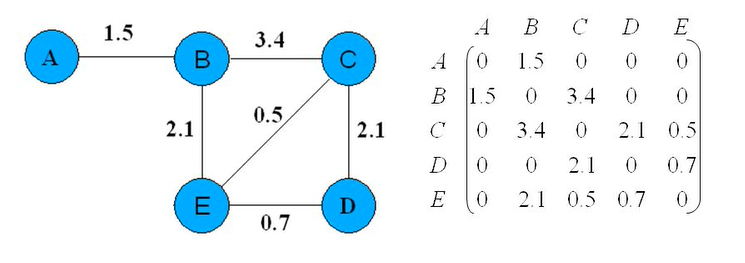

The function `from_numpy_matrix` form [NetworkX](https://networkx.org/) returns a graph from numpy matrix. A visual represenation of the distance between features (and a first hint of their clustering properties) can be obtained by selecting a subset of the complete graph obtained from the distance matrix. This subset is called *minimum spanning tree*. As per wikipedia

> A minimum spanning tree (MST) is a subset of the edges of a connected, edge-weighted undirected graph that connects all the vertices together, without any cycles and with **the minimum possible total edge weight**.

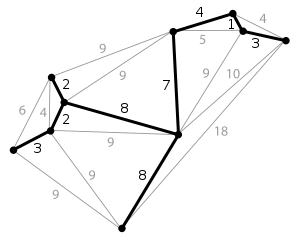
A minimum spanning tree structure incorporates hierarchical relationships

In [ ]:
# Complete graph from distance matrix
G = nx.from_numpy_matrix(dist.to_numpy())

labels = dist.columns.values
labels = [s.replace('ft_','') for s in labels]
G = nx.relabel_nodes(G, dict(zip(range(len(labels)), labels)))

In [ ]:
# Minimum spanning tree
T=nx.minimum_spanning_tree(G)

fig = plt.figure(figsize=(20,20))
nx.draw_networkx(T,
                 with_labels=True, 
                 font_size=9, 
                 cmap=plt.cm.coolwarm,
                 pos=nx.kamada_kawai_layout(T),vmin=0, vmax=1)
plt.show()

Just looking  at the Spanning Tree, we can see that there are features that are so highly correlated that they are almost indistinguishable in the image. For example, `ft_60`-`ft_61` (correlation coefficient $\rho = 0.995$), `ft_65`-`ft_66` ($\rho = 0.995$), `ft_62`-`ft_63` ($\rho = 0.998$), `ft_67`-`ft_68` ($\rho = 0.999$), `ft_90`-`ft_114`-`ft_102` ($\rho = 0.996$) and so on. The condition under which one predictor variable can be linearly predicted by the others is called [*multicollinearity*] (https://en.wikipedia.org/wiki/Multicollinearity#Consequences_of_multicollinearity). Depending on the predictive model, the presence of multicollinearity may have an impact on model performance. In certain contexts, it is therefore desirable to manage interdependent features [[7]](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features) [[8]](https://datascience.stackexchange.com/questions/65815/chose-among-highly-correlated-variables).

### 3.2 Correlation-based clustering

Now that we have a distance matrix, we can use it to perform a hierarchical agglomerative cluster. A a step-by-step explaination of this process can be found in Chap.16 of [2]. 

In [ ]:
# Linkage matrix
link=sch.linkage(dist,'average')

In [ ]:
# Plot dendrogram

fig = plt.figure(figsize=(20, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.hlines(1.6,0,1320)
dn = sch.dendrogram(link,leaf_rotation=90.,leaf_font_size=11.)
plt.show()

We are now in the position of having to choose the optimal number of clusters. We must decide where to "cut" the dendrogram to consider all features below the horizontal line as belonging to the same cluster. There are a variety of techniques to determine the optimal number of clusters[[9]](https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/) [[10]](https://stats.stackexchange.com/questions/23472/how-to-decide-on-the-correct-number-of-clusters)[[11]](https://stats.stackexchange.com/questions/3685/where-to-cut-a-dendrogram). We will not go into too much technical detail (the purpose of this notebook is to give an overview of hierarchical clustering). 

We follow a simple approach: we find the longest vertical line that is not interrupted by a horizontal line. There are several techniques that are far more sophisticated than the one I used here to determine the optimal number of clusters. This "longest vertical line" approach is the "zeroth-order" solution, and the intuitive explanation is that the length of the vertical lines represents the distance between the sub-clusters. We can think of the longest vertical line as the level where the longest inter-cluster distance occurs.

In [ ]:
# fcluster forms flat clusters from the hierarchical clustering defined by the given linkage matrix.

max_d = 1.6
clusters = fcluster(link,t=max_d, criterion='distance')

In [ ]:
df_clust = pd.DataFrame({'Cluster':clusters, 'Features':ft.columns.values.astype('str')})
df_clust.groupby('Cluster').count()

The hierarchical clustering algorithm, with correlation-based distance and average distance as linkage criteria, identifies 8 clusters. The largest cluster contains 25 features, the smallest only 6.

In [ ]:
# Save the cluster-feature in a dictionary 
clust_feat = {}
for k in np.unique(clusters):
    clust_feat[k] = df_clust[df_clust.Cluster == k].Features.values

In [ ]:
for k in np.unique(clusters):
    print('Cluster_{}'.format(k,2),'->', df_clust[df_clust.Cluster == k].Features.values)

### 3.3 Quasi-Diagonalization

In this step, the rows and columns of the correlation matrix are reordered so that the largest values lie along the diagonal. This quasi-diagonalization of the covariance matrix doesn not require a change in basis and it returns a block-diagonal matrix where similar columns are placed together and dissimilar columns are placed far apart. Code below from [2]

In [ ]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int)
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3] # number of original items
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space
        df0=sortIx[sortIx>=numItems] # find clusters
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0) # item 2
        sortIx=sortIx.sort_index() # re-sort
        sortIx.index=range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

In [ ]:
sortIx=getQuasiDiag(link)
sortIx=corr_mat.index[sortIx].tolist() # recover labels
corr_diag=corr_mat.loc[sortIx,sortIx] # reorder

sortIx=getQuasiDiag(link)
sortIx=dist.index[sortIx].tolist() # recover labels
dist_diag=dist.loc[sortIx,sortIx] # reorder


In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(23,9))

sns.heatmap(corr_diag,ax= ax1, cmap='coolwarm');
sns.heatmap(dist_diag,ax= ax2, cmap='coolwarm');
ax1.title.set_text('Quasi-diagonal Correlation matrix')
ax2.title.set_text('Quasi-diagonal Distance matrix')
plt.show()

## 4. Information-based distance

The notion of correlation has three important [pitfalls](10.4103/2229-3485.192046). First, it quantifies the linear relationship between two random variables. Therefore, it may be fallacious in situations where two variables are interdependent in a nonlinear way. Second, correlation is very sensitive to outliers. Finally, its application beyond the multivariate case is questionable.

To overcome these caveats, it is possible to introduce a new distance based on information-theoretic concepts.
This quantity is called Variation of Information. Given two random variables $X$ and $Y$, the [variation of information](https://en.wikipedia.org/wiki/Variation_of_information) between $X$ and $Y$ is defined as: 

$VI[X,Y] = 1 - \frac{I[X,Y]}{H[X,Y]}$,

where $I[X,Y]$ is the mutual information between $X$ and $Y$ and $H[X,Y]$ is the joint entropy. See [2] for a detailed explanation. To compute the variation of information, we need to bin our observations. The following functions (from [2]) compute the optimal number of bins and the Variation of Information.

In [ ]:
def numBins(nObs,corr=None):
    # Optimal number of bins for discretization
    if corr is None: # univariate case
        z=(8+324*nObs+12*(36*nObs+729*nObs**2)**.5)**(1/3.)
        b=round(z/6.+2./(3*z)+1./3)
    else: # bivariate case
        b=round(2**-.5*(1+(1+24*nObs/(1.-corr**2))**.5)**.5)
    return int(b)

In [ ]:
def varInfo(x,y,norm=False):
    if (x == y).all():
        return 0
    # variation of information
    bXY=numBins(x.shape[0],corr=np.corrcoef(x,y)[0,1])
    cXY=np.histogram2d(x,y,bXY)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal
    hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal
    vXY=hX+hY-2*iXY # variation of information
    if norm:
        hXY=hX+hY-iXY # joint
        vXY/=hXY # normalized variation of information
    return vXY

Let's calculate the variation of information for our features and see what happens. 

(The execution of the following section takes about 20 min. If there is someone who has the good will to improve the function, he/she has all my gratitude and respect).

In [ ]:
# Drop NaNs and calculate variation of information
ft_red = ft.dropna()
V = np.zeros(corr_diag.shape)

for i in range(corr_mat.shape[0]):
    for j in range(i):
        x = ft_red.iloc[:,i]
        y = ft_red.iloc[:,j]
        V[i,j] = varInfo(x,y,norm=True)



In [ ]:
dist_info = pd.DataFrame(V + V.T,columns=ft.columns,index=ft.columns)
dist_info

### 4.1 Graph representation

As in the correlation-based case, we can create a minumum spanning tree to visualize the *features network*.

In [ ]:
# Fully connected graph
X = dist_info.to_numpy()
G = nx.from_numpy_matrix(X)

# Minumum spanning tree
labels = dist.columns.values
G = nx.relabel_nodes(G, dict(zip(range(len(labels)), labels)))
T=nx.minimum_spanning_tree(G)

# MST Plot
fig = plt.figure(figsize=(20, 20))
nx.draw_networkx(T, with_labels=True, font_size=12, node_size=60,pos=nx.kamada_kawai_layout(T))
plt.show()

The spanning tree calculated from the information-based metric seems more *stretched*. The features seem to be further apart and less clustered. However, the features that we had identified as highly correlated are also extremely close here (`ft_60`-`ft_61`, `ft_65`-`ft_66`, `ft_62`-`ft_63`, `ft_67`-`ft_68` and so on. Let's see what happens when we plot the distance matrix and compare it to the distance matrix obtained from the correlation based distance.

### 4.2 Information-based clustering

As in the correlation-based case, we can use the distance matrix to obtain a linkage matrix and the final clustering. Before proceeding further, it is interesting to compare the correlation-based distance matrix and with the information-based distance matrix.

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(23,9))

sns.heatmap(dist,     ax= ax1, cmap='coolwarm');
sns.heatmap(dist_info,ax= ax2, cmap='coolwarm');
ax1.title.set_text('Correlation-based Distance')
ax2.title.set_text('Information-based Distance')
plt.show()

Correlation-based and information-based distance matrices show very similar patterns. The information-based distance is on average higher than its correlation-based counterpart (see chart below). It would be interesting to investigate this result further: Does it mean that the information distance is "less sensitive"? Or perhaps that it is better able to detect meaningful relationships?

In [ ]:
plt.figure(figsize=(21,8))

plt.plot(dist.mean())
plt.plot(dist_info.mean())
plt.title('Average distance')
plt.legend(('Correlation distance','Information distance'))
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.xticks(rotation=90,fontsize=9)
plt.show()

Let's proceed with the linkage matrix.

In [ ]:
link_info=sch.linkage(dist_info,'average')


In [ ]:
fig = plt.figure(figsize=(20, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.hlines(1.6,0,1320)
dn = sch.dendrogram(link_info,leaf_rotation=90.,leaf_font_size=12.)
plt.show()

In [ ]:
# fcluster forms flat clusters from the hierarchical clustering defined by the given linkage matrix.

max_d = 1.6
clusters = fcluster(link_info,t=max_d, criterion='distance')

In [ ]:
df_clust = pd.DataFrame({'Cluster':clusters, 'Features':ft.columns.values.astype('str')})
df_clust.groupby('Cluster').count()

In [ ]:
for k in np.unique(clusters):
    print('Cluster_{}'.format(k,2),'->', df_clust[df_clust.Cluster == k].Features.values)

The hierarchical clustering algorithm identifies 6 clusters when the information-based distance is used. However, four of these clusters are de facto small groups of highly correlated features:

`Cluster_2 -> ['ft_62' 'ft_63']`
`Cluster_3 -> ['ft_60' 'ft_61']`
`Cluster_5 -> ['ft_67' 'ft_68']`
`Cluster_6 -> ['ft_64' 'ft_65' 'ft_66']`

A debatable point is: does it make sense to use the same threshold distance max_d = 1.6 as in the correlation-based case? In my opinion, the answer is: not necessarily. Using the same threshold distance makes sense in this case to compare results between two different methods, but it is important to keep in mind that correlation-based and information-based are two different metrics. To put it simply: We need to be careful not to compare kilometers and miles.

Comparing different dendrograms and different methods would require a whole separate notebook, and I will not dwell on it too much. See the References section for links to a couple of interesting threads on StackExchange that discuss these topics in detail.

### 4.3 Quasi-diagonalization

In [ ]:
sortIx=getQuasiDiag(link_info)
sortIx=dist_info.index[sortIx].tolist() # recover labels
dist_info_diag=dist_info.loc[sortIx,sortIx] # reorder

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(23, 9))

sns.heatmap(dist_diag,     ax= ax1, cmap='coolwarm');
sns.heatmap(dist_info_diag,ax= ax2, cmap='coolwarm');
ax1.title.set_text('Correlation-based quasi-diagonal distance')
ax2.title.set_text('Information-based quasi-diagonal distance')
plt.show()

## 5 Final toughts and possible improvement

In this notebook we have studied the hierarchical clustering of features with two different definitions of distance: the first based on Pearson's correlation coefficient, the second on the Variation of Information. We derived a linkage matrix from the distance matrix and used it to group the features into clusters. To visualize the result, we used dendrograms and minimum spanning trees. The correlation-based approach identifies eight clusters. The information-based one only six, although two of these six are massive clusters with 82 and 40 features, respectively. The remaining four are just small groups of highly codependent features. One reason for this may be the questionable choice of a threshold distance `max_d = 1.6`, which is the same distance as in the correlation-based case.

What we have shown so far is a fairly 'out of the box' implementation. The goal was primarily to show these techniques and provide a baseline for those interested in exploring beyond this approach. There are a number of improvements or more in-depth studies that can be done. For example:

1. test more robust criteria for determining the optimal number of clusters.

2. test alternative linkage criteria ("single", "weighted", "ward", etc.).

3. use random matrix theories to denoise the correlation matrix.

4. investigate the optimal threshold distance for the information-based case,

Thank you for making it this far. I hope you have enjoyed this work. If you have any comments, questions or observations, please let's discuss them in the comment section.

## References

[1] **Vladimir Estivill-Castro.** (2002). Why so many clustering algorithms: a position paper. SIGKDD Explor. Newsl. 4, 1 (June 2002), 65–75. DOI:https://doi.org/10.1145/568574.568575

[2] **López de Prado, M.** (2020) - Machine Learning for Asset Managers (Elements in Quantitative Finance). Cambridge: Cambridge University Press. doi:10.1017/9781108883658

[3] **López de Prado, M.** (2018) - Advances in Financial Machine Learning (1st. ed.). Wiley Publishing.

[4] [StackExchange - Choosing the right linkage method for hierarchical clustering](https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering)

[5] [StackExchange - How to select a clustering method? How to validate a cluster solution?](https://stats.stackexchange.com/questions/195456/how-to-select-a-clustering-method-how-to-validate-a-cluster-solution-to-warran)

[6] [StackExchange - Comparing hierarchical clustering dendrograms obtained by different distances & methods](https://stats.stackexchange.com/questions/63546/comparing-hierarchical-clustering-dendrograms-obtained-by-different-distances/63549#63549)

[7] [StackExchange - In supervised learning, why is it bad to have correlated features?](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)

[8] [StackExchange - Chose among highly correlated variables](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)

[9] [DataNovia - Determining The Optimal Number Of Clusters: 3 Must Know Methods](https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/)

[10] [StackExchange - How to decide on the correct number of clusters?](https://stats.stackexchange.com/questions/23472/how-to-decide-on-the-correct-number-of-clusters)

[11] [StackExchange - Where to cut a dendrogram?](https://stats.stackexchange.com/questions/3685/where-to-cut-a-dendrogram)

[12] [Kaggle Notebook - Hierarchical Clustering](https://www.kaggle.com/biphili/hierarchical-clustering) by @Binu